In [26]:
import cv2
import time
import numpy as np

In [11]:
def preprocess_video(video_path, target_fps=10, target_size=(320, 240)):
    """
    Reads a video, resamples it to a fixed fps, converts to grayscale,
    and resizes frames.
    
    Args:
        video_path (str): Path to the input video file.
        target_fps (int): Desired frames per second (S=10 in paper).
        target_size (tuple): Desired resolution (Width, Height) -> (320, 240).
        
    Returns:
        np.array: A numpy array of processed frames with shape (Num_Frames, 240, 320).
    """

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return None

    # Get original video properties
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / original_fps

    print(f"Original Video: {original_fps} fps, {duration:.2f} seconds")
    processed_frames = []

    time_interval = 1.0 / target_fps 
    current_time = 0.0

    while True:
        # Calculate which frame number corresponds to the current timestamp
        frame_id = int(current_time * original_fps)

        # Set the video reader to look at that specific frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)

        ret, frame = cap.read()
        
        # If we run out of frames, stop
        if not ret:
            break

        # Convert to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize frame
        resized_frame = cv2.resize(gray_frame, target_size)

        processed_frames.append(resized_frame)

        current_time += time_interval

        # Safety break if we exceed video duration
        if current_time > duration:
            break

    cap.release()
    return np.array(processed_frames)

In [14]:
def preprocess_video_optimized(video_path, target_fps=10, target_size=(320, 240)):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    # Video properties
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    total_src_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the "Step" (e.g., if Source is 30fps and Target is 10fps, step is 3)
    step = original_fps / target_fps
    
    print(f"Optimization: Processing 1 out of every {step:.2f} frames...")

    processed_frames = []
    
    current_src_frame = 0  # Where we are in the source video
    target_frame_count = 0 # How many frames we have captured so far
    
    while True:
        should_decode = current_src_frame >= (target_frame_count * step)

        if should_decode:
            # RETRIEVE: Actually decode the image (Heavy work)
            ret, frame = cap.read()
            if not ret: break
            
            # Process it
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            resized_frame = cv2.resize(gray_frame, target_size, interpolation=cv2.INTER_AREA)
            processed_frames.append(resized_frame)
            
            target_frame_count += 1
        else:
            ret = cap.grab()
            if not ret: break
            
        current_src_frame += 1

    cap.release()
    print(f"Done! Processed {len(processed_frames)} frames.")
    return np.array(processed_frames)


In [17]:
def extract_fingerprint(frames):
    """
    Converts a stack of frames into fingerprints.
    
    Args:
        frames (np.array): Shape (N, 240, 320), grayscale.
        
    Returns:
        np.array: Shape (N, 8). The fingerprints.
    """

    fingerprints = []

    # Grid parameters
    N_ROWS = 2 
    M_COLS = 4 

    # Get image dimensions
    if len(frames) == 0: return np.array([])
    img_h, img_w = frames[0].shape

    # Calculate block sizes
    blk_h = img_h // N_ROWS 
    blk_w = img_w // M_COLS 

    print(f"Extracting fingerprints from {len(frames)} frames...")

    for k, frame in enumerate(frames):
        # Compute gradients
        gx = cv2.Sobel(frame, cv2.CV_64F, 1, 0, ksize=1)
        gy = cv2.Sobel(frame, cv2.CV_64F, 0, 1, ksize=1)    

        # magnitude (r)
        magnitude = np.sqrt(gx**2 + gy**2) 

        # orientation (theta)
        orientation = np.arctan2(gy, gx)

        frame_fingerprint = []

        for n in range(N_ROWS):
            for m in range(M_COLS):
                # Define the slice for this block
                y_start = n * blk_h
                y_end   = (n + 1) * blk_h
                x_start = m * blk_w
                x_end   = (m + 1) * blk_w

                # Extract r and theta for just this block
                mag_block = magnitude[y_start:y_end, x_start:x_end]
                ori_block = orientation[y_start:y_end, x_start:x_end]

                # Calculate the Centriod
                numerator = np.sum(mag_block * ori_block)
                denominator = np.sum(mag_block)

                # Avoid divide by zero
                if denominator == 0:
                    centroid = 0.0
                else:
                    centroid = numerator / denominator

                frame_fingerprint.append(centroid)

        fingerprints.append(frame_fingerprint)

    return np.array(fingerprints)

In [16]:
if __name__ == "__main__":
    # Create a dummy video file or use a real path
    video_file = "./data/db/sample1.mp4" 
    
    # NOTE: Ensure you have a video file named 'test_video.mp4' in the folder
    # or change the path to a real video on your computer.
    
    try:
        frames = preprocess_video_optimized(video_file)
        if frames is not None:
            print(f"Success! Processed {len(frames)} frames.")
            print(f"Shape of output: {frames.shape}") # Should be (Count, 240, 320)
            
            # Optional: Show the first processed frame to verify
            cv2.imshow("Processed Frame 0", frames[0])
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            
    except Exception as e:
        print(f"An error occurred: {e}")
        print("Make sure you have a valid video file path.")

Optimization: Processing 1 out of every 3.00 frames...
Done! Processed 15522 frames.
Success! Processed 15522 frames.
Shape of output: (15522, 240, 320)


In [ ]:
if __name__ == "__main__":
    try:
        db_fingerprints = extract_fingerprint(frames)
        print(f"Fingerprints Extracted!")
        print(f"Output Shape: {db_fingerprints.shape}")
    except Exception as e:
        print(f"Error: {e}")

Extracting fingerprints from 15522 frames...
Fingerprints Extracted!
Output Shape: (15522, 8)


Visualizing Frame 0
Fingerprint Data (Angles): [  8  22  12  21   0  -9 -11   7]


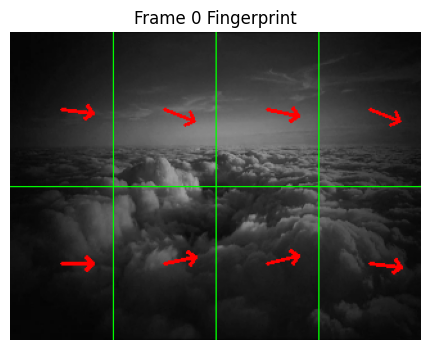

Visualizing Frame 50
Fingerprint Data (Angles): [41 27 12 22  9 10  1  9]


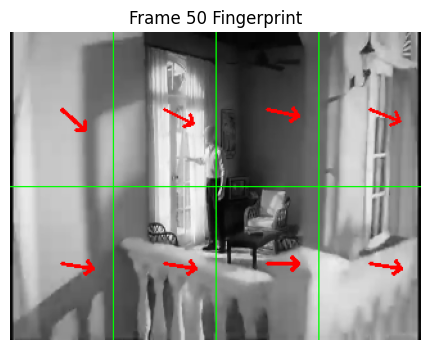

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_real_fingerprint(frames_array, fingerprints_array, frame_idx=0):
    """
    Visualizes the fingerprint for a specific frame from your processed video.
    """
    # 1. Get the specific frame and its fingerprint
    if frame_idx >= len(frames_array):
        print(f"Error: Frame index {frame_idx} is out of bounds.")
        return

    frame_gray = frames_array[frame_idx]
    fingerprint = fingerprints_array[frame_idx]

    # Convert to Color (RGB) so we can draw red/green lines on it
    # Matplotlib expects RGB, OpenCV usually does BGR, but since we started Gray...
    viz_img = cv2.cvtColor(frame_gray, cv2.COLOR_GRAY2RGB)
    
    # 2. Setup Grid Parameters (Same as Phase 2)
    h, w = viz_img.shape[:2] # Should be 240, 320
    rows, cols = 2, 4
    blk_h = h // rows
    blk_w = w // cols
    
    # 3. Draw the Green Grid
    for r in range(1, rows):
        y = r * blk_h
        cv2.line(viz_img, (0, y), (w, y), (0, 255, 0), 1)
    for c in range(1, cols):
        x = c * blk_w
        cv2.line(viz_img, (x, 0), (x, h), (0, 255, 0), 1)

    # 4. Draw the Red Arrows
    arrow_len = 25
    
    print(f"Visualizing Frame {frame_idx}")
    print(f"Fingerprint Data (Angles): {np.degrees(fingerprint).astype(int)}")

    for i, angle in enumerate(fingerprint):
        # Calculate grid position (Row, Col)
        r = i // cols
        c = i % cols
        
        # Center of the block
        center_x = c * blk_w + (blk_w // 2)
        center_y = r * blk_h + (blk_h // 2)
        
        # Calculate End Point of Arrow
        # Note: In image coords, Y is down. 
        # To make the arrow visually match the math direction:
        end_x = int(center_x + arrow_len * np.cos(angle))
        end_y = int(center_y + arrow_len * np.sin(angle))
        
        # Draw Arrow
        cv2.arrowedLine(viz_img, (center_x, center_y), (end_x, end_y), (255, 0, 0), 2, tipLength=0.3)

    # 5. Show Image
    plt.figure(figsize=(6, 4))
    plt.imshow(viz_img)
    plt.title(f"Frame {frame_idx} Fingerprint")
    plt.axis('off')
    plt.show()

# --- RUN THIS ---
# Change '100' to whatever frame number you want to inspect
visualize_real_fingerprint(frames, db_fingerprints, frame_idx=0)
visualize_real_fingerprint(frames, db_fingerprints, frame_idx=50)

In [ ]:
def search_video(database_fps, query_fps):
    """
    Scans the database to find the query.
    
    Args:
        database_fps (np.array): The long chain of fingerprints (Full Movie).
        query_fps (np.array): The short chain (The 10s clip).
        
    Returns:
        best_idx (int): The frame number where the match starts.
        min_dist (float): The distance score (Lower is better).
    """
    K = len(query_fps) # Sequence length (e.g., 100 frames)
    N_db = len(database_fps)
    
    # We need at least enough frames in the DB to fit the query
    if N_db < K:
        print("Error: Query is longer than the Database!")
        return -1, 999.0

    min_dist = float('inf')
    best_idx = -1
    
    print(f"Searching database of {N_db} frames with a query of {K} frames...")
    start_time = time.time()
    
    for i in range(N_db - K + 1):
        db_window = database_fps[i : i + K]
        
       
        # diff = (p - q)
        diff = db_window - query_fps
    
        dist = np.mean(diff ** 2)
        
        # 3. Check if this is the best match so far
        if dist < min_dist:
            min_dist = dist
            best_idx = i
            
    elapsed = time.time() - start_time
    print(f"Search complete in {elapsed:.4f} seconds.")
    
    return best_idx, min_dist

In [28]:
if __name__ == "__main__":
    # Assuming 'db_fingerprints' exists from Phase 2
    # Let's pretend we recorded a clip starting at Frame 250
    TRUE_START_FRAME = 250
    CLIP_LENGTH = 100 # 10 seconds
    
    # 1. Create a "Fake" Query by slicing the database
    # (In real life, this would come from a separate video file)
    query_data = db_fingerprints[TRUE_START_FRAME : TRUE_START_FRAME + CLIP_LENGTH]
    
    # 2. Run the Search
    found_idx, score = search_video(db_fingerprints, query_data)
    
    # 3. Results
    print(f"\n--- RESULTS ---")
    print(f"True Start Frame: {TRUE_START_FRAME}")
    print(f"Found Start Frame: {found_idx}")
    print(f"Difference Score: {score:.10f}") # Should be 0.0 for a perfect copy
    
    if found_idx == TRUE_START_FRAME:
        print(">> MATCH FOUND! <<")
    else:
        print(">> MATCH FAILED <<")

Searching database of 15522 frames with a query of 100 frames...
Search complete in 0.1101 seconds.

--- RESULTS ---
True Start Frame: 250
Found Start Frame: 250
Difference Score: 0.0000000000
>> MATCH FOUND! <<


In [ ]:
import numpy as np
import os
# Import the classes we wrote in previous steps
from database_system import VideoDatabase, preprocess_video_optimized, extract_fingerprint
from distortion import apply_distortions

def run_verification_test(video_path):
    # 1. SETUP DATABASE
    db = VideoDatabase("test_db")
    
    # Clear old data for a fresh test
    if os.path.exists(db.meta_path):
        os.remove(db.meta_path)
    for f in os.listdir(db.fp_folder):
        os.remove(os.path.join(db.fp_folder, f))
        
    print(f"--- 1. ADDING VIDEO TO DB: {video_path} ---")
    db.add_video(video_path)
    
    # 2. CREATE A "MYSTERY" CLIP
    print(f"\n--- 2. CREATING DISTORTED QUERIES ---")
    # Grab frames 100-200 (10 seconds)
    full_frames = preprocess_video_optimized(video_path)
    clean_clip = full_frames[100:200]
    
    # Distort them
    distorted_versions = apply_distortions(clean_clip)
    
    # 3. RUN SEARCH TESTS
    print(f"\n--- 3. SEARCHING... ---")
    
    results = []
    
    for attack_name, bad_frames in distorted_versions.items():
        print(f"Testing Attack: {attack_name.upper()}")
        
        # Extract fingerprint from the BAD video
        query_fp = extract_fingerprint(bad_frames)
        
        # Search the CLEAN database
        match = db.search(query_fp)
        
        if match:
            print(f"  >> MATCH! Found '{match['video']}' at {match['start_time']}s")
            print(f"  >> Confidence Score: {match['score']:.4f}")
            results.append((attack_name, True))
        else:
            print(f"  >> FAILED to find match.")
            results.append((attack_name, False))
            
    # 4. REPORT CARD
    print(f"\n--- FINAL REPORT ---")
    for name, success in results:
        status = "PASSED" if success else "FAILED"
        print(f"Test '{name}': {status}")

if __name__ == "__main__":
    # Point this to a real video file on your PC
    VIDEO_FILE = "test_video.mp4" 
    run_verification_test(VIDEO_FILE)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from database_system import VideoDatabase  # Import your DB class

def visualize_db_entry(db, file_id, frame_idx=0):
    """
    Visualizes a specific frame and its fingerprint from the database.
    Automatically finds the original video file to show the background image.
    """
    # 1. Load Metadata
    if file_id not in db.metadata:
        print(f"Error: ID {file_id} not found in database.")
        return

    meta = db.metadata[file_id]
    video_path = meta['original_path']
    print(f"Visualizing: {meta['name']} | Frame: {frame_idx}")

    # 2. Load the Fingerprint (Math)
    npy_path = os.path.join(db.fp_folder, f"{file_id}.npy")
    # Use mmap to load just the one row we need
    full_fp_array = np.load(npy_path, mmap_mode='r')
    
    if frame_idx >= len(full_fp_array):
        print(f"Error: Frame {frame_idx} exceeds duration ({len(full_fp_array)} frames)")
        return
        
    fingerprint = full_fp_array[frame_idx]

    # 3. Load the Frame Image (Visual)
    # We need to calculate the timestamp because the original video 
    # might be 30fps but our db is 10fps.
    # Estimated timestamp = frame_idx * (1 / 10.0)
    timestamp = frame_idx / 10.0
    
    cap = cv2.VideoCapture(video_path)
    # Jump to the specific time
    cap.set(cv2.CAP_PROP_POS_MSEC, timestamp * 1000)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Error: Could not read frame from original video file.")
        return

    # Resize to standard analysis size (320x240) to match the grid logic
    frame_resized = cv2.resize(frame, (320, 240))
    
    # 4. Draw the Visualization
    _draw_overlay(frame_resized, fingerprint, title=f"Frame {frame_idx} ({timestamp}s)")

def _draw_overlay(frame_bgr, fingerprint, title="Fingerprint"):
    """Helper function to draw the grid and arrows."""
    # Convert to RGB for Matplotlib
    viz_img = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    
    h, w = viz_img.shape[:2]
    rows, cols = 2, 4
    blk_h, blk_w = h // rows, w // cols
    
    # Draw Faint Grid
    for r in range(1, rows):
        y = r * blk_h
        cv2.line(viz_img, (0, y), (w, y), (0, 255, 0), 1)
    for c in range(1, cols):
        x = c * blk_w
        cv2.line(viz_img, (x, 0), (x, h), (0, 255, 0), 1)

    # Draw Arrows
    arrow_len = 25
    for i, angle in enumerate(fingerprint):
        r, c = i // cols, i % cols
        cx, cy = c * blk_w + (blk_w // 2), r * blk_h + (blk_h // 2)
        
        # End point
        end_x = int(cx + arrow_len * np.cos(angle))
        end_y = int(cy + arrow_len * np.sin(angle))
        
        # Color based on angle (just for fun/clarity)
        # Map angle -pi..pi to Hue 0..179
        hue = int( ((angle + np.pi) / (2*np.pi)) * 179 )
        # We need to convert this single color to RGB
        color_hsv = np.uint8([[[hue, 255, 255]]])
        color_rgb = cv2.cvtColor(color_hsv, cv2.COLOR_HSV2RGB)[0][0]
        color_tuple = (int(color_rgb[0]), int(color_rgb[1]), int(color_rgb[2]))

        cv2.arrowedLine(viz_img, (cx, cy), (end_x, end_y), color_tuple, 2, tipLength=0.3)

    plt.figure(figsize=(6, 4))
    plt.imshow(viz_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_search_score(db_fingerprints, query_fingerprints):
    """
    Plots the 'Distance Score' for every position in the video.
    This shows you exactly where the match happened.
    """
    K = len(query_fingerprints)
    scores = []
    
    # Calculate scores for sliding window
    # (Note: For visualization, we do this un-optimized loop to plot the graph)
    for i in range(len(db_fingerprints) - K + 1):
        window = db_fingerprints[i : i+K]
        diff = window - query_fingerprints
        score = np.mean(diff**2)
        scores.append(score)
        
    scores = np.array(scores)
    
    # Find best match
    min_idx = np.argmin(scores)
    min_score = scores[min_idx]
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(scores, label="Difference Score", color='gray')
    
    # Highlight the match
    plt.plot(min_idx, min_score, 'ro', label=f"Best Match (Frame {min_idx})")
    
    # Draw Threshold Line (T=0.4 from paper)
    plt.axhline(y=0.4, color='g', linestyle='--', label="Threshold (0.4)")
    
    plt.xlabel("Frame Index")
    plt.ylabel("Euclidean Distance")
    plt.title("Search Scan: Lower is Better")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- USAGE ---
if __name__ == "__main__":
    db = VideoDatabase("test_db")
    
    if len(db.metadata) > 0:
        # Get the first file ID
        test_id = list(db.metadata.keys())[0]
        
        # 1. Visualizing the arrows on Frame 100
        visualize_db_entry(db, test_id, frame_idx=100)
        
        # 2. Visualizing the Search Graph
        # Load data to simulate a search
        full_fps = np.load(os.path.join(db.fp_folder, f"{test_id}.npy"))
        
        # Create a query (Frames 200-300)
        query = full_fps[200:300]
        
        # Show the plot
        print("Generating Search Plot...")
        visualize_search_score(full_fps, query)